In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

import plotly.express as px

plt.rcParams['font.family'] = "NanumGothic"
plt.rcParams['axes.unicode_minus'] = False

pd.options.plotting.backend = "plotly"

In [2]:
df_train = pd.read_csv("./data/train.csv",dtype={'일시':int})

In [3]:
df_train.head()

,일시,광진구,동대문구,성동구,중랑구
0,20180101,0.592,0.368,0.580,0.162
1,20180102,0.840,0.614,1.034,0.260
2,20180103,0.828,0.576,0.952,0.288
3,20180104,0.792,0.542,0.914,0.292
4,20180105,0.818,0.602,0.994,0.308


# Eda

## 지역별

In [4]:
df_train[['광진구','동대문구','성동구','중랑구']].sum()

광진구     9071.632
동대문구    6185.392
성동구     7572.292
중랑구     4585.710
dtype: float64

In [5]:
df_train[df_train['일시'] >20210000][['광진구','동대문구','성동구','중랑구']].sum()

광진구     2980.482
동대문구    2431.168
성동구     2525.024
중랑구     1744.470
dtype: float64

In [6]:
df_train[(df_train['일시'] > 20200000) & (df_train['일시'] <20210000)][['광진구','동대문구','성동구','중랑구']].sum()

광진구     2398.756
동대문구    1693.428
성동구     2110.926
중랑구     1352.612
dtype: float64

In [7]:
df_train[(df_train['일시'] > 20190000) & (df_train['일시'] <20200000)][['광진구','동대문구','성동구','중랑구']].sum()

광진구     2415.974
동대문구    1342.088
성동구     1820.168
중랑구      977.896
dtype: float64

In [8]:
df_train[(df_train['일시'] > 20180000) & (df_train['일시'] <20190000)][['광진구','동대문구','성동구','중랑구']].sum()

광진구     1276.420
동대문구     718.708
성동구     1116.174
중랑구      510.732
dtype: float64

## 패턴, 추세

In [9]:
def dfByDateRange(dt_start:datetime,dt_end:datetime):
    dts=[]
    dt_cur = dt_start
    while dt_cur <= dt_end:
        dts.append(dt_cur.year*10000 + dt_cur.month*100 + dt_cur.day)
        dt_cur += timedelta(days=1)

    return pd.DataFrame({'일시': dts})

In [10]:
def preprocess(df,holiday_path,makeY=False):
    df_holiday =  pd.read_csv(holiday_path,dtype={'locdate':int})

    holidays = df_holiday['locdate'].apply(lambda x : datetime(year=int(x//1e4), month = int((x%1e4)//100), day=int(x%100)))
    
    df_features = pd.DataFrame()
    df_features['date'] = df['일시'].apply(lambda x : datetime(year=int(x//1e4), month = int((x%1e4)//100), day=int(x%100)))
    df_features['weekday'] = df_features['date'].apply(lambda date : date.weekday()) / 7.0
    df_features['weekend'] =  df_features['date'].apply(lambda date : date.weekday() == 5 or date.weekday() == 6)
    df_features['month'] = df_features['date'].apply(lambda date : date.month) / 12.0
    #df_features['day_of_month']= df_features['date'].apply(lambda date : date.day) 
    df_features['day_of_year'] = df_features['date'].apply(lambda date : date.timetuple().tm_yday) / 365.0 
    df_features['red'] = df_features['date'].isin(holidays) 
    df_features['year'] = df_features['date'].apply(lambda date : date.year) / 2018.0
    df_features['week_of_year']=df_features['date'].apply(lambda date : date.isocalendar()[1]) / 53.0

    df_features['vacation'] = False
    df_features['rainy_season'] = df_features['date'].apply(lambda date : 726 >= date.month*100 + date.day >= 625)

    for i in range(1,df_features.shape[0]-1):
        if df_features["red"][i] & df_features["red"][i-1] & df_features["red"][i+1]:
            df_features.at[i-1,"vacation"] = True
            df_features.at[i,"vacation"] = True
            df_features.at[i+1,"vacation"] = True


    cols_location = ['광진구','동대문구','성동구','중랑구']
    list_df_features_by_loc = []
    for idx, loc in enumerate(cols_location):
        df_new = df_features.copy()
        df_new['loc'] = idx
        if makeY:
            df_new['y']=df[loc]
        list_df_features_by_loc.append(df_new)

    df_ret=pd.concat(list_df_features_by_loc)
    df_ret = df_ret.reset_index(drop=True)

    #df_ret = df_ret.drop('date',axis=1)

    return df_ret


In [11]:
df_processed = preprocess(df_train,'./data/holiday_train.csv',makeY=True)


In [12]:
df_processed

,date,weekday,weekend,month,day_of_year,red,year,week_of_year,vacation,rainy_season,loc,y
0,2018-01-01,0.000000,False,0.083333,0.002740,True,1.000000,0.018868,False,False,0,0.592
1,2018-01-02,0.142857,False,0.083333,0.005479,False,1.000000,0.018868,False,False,0,0.840
2,2018-01-03,0.285714,False,0.083333,0.008219,False,1.000000,0.018868,False,False,0,0.828
3,2018-01-04,0.428571,False,0.083333,0.010959,False,1.000000,0.018868,False,False,0,0.792
4,2018-01-05,0.571429,False,0.083333,0.013699,False,1.000000,0.018868,False,False,0,0.818
...,...,...,...,...,...,...,...,...,...,...,...,...
5839,2021-12-27,0.000000,False,1.000000,0.989041,False,1.001487,0.981132,False,False,3,2.350
5840,2021-12-28,0.142857,False,1.000000,0.991781,False,1.001487,0.981132,False,False,3,2.700
5841,2021-12-29,0.285714,False,1.000000,0.994521,False,1.001487,0.981132,False,False,3,2.524
5842,2021-12-30,0.428571,False,1.000000,0.997260,False,1.001487,0.981132,False,False,3,2.506


In [13]:
fig = px.line(df_processed,x="date",y="y",color="loc")

for index, row in df_processed[:df_processed.shape[0]//4].iterrows():
    if row['weekend']: 
        fig.add_shape(type="rect",
                        xref="x",
                        yref="paper",
                        x0=row['date'],
                        y0=0,
                        x1=row['date'] + pd.DateOffset(1),
                        y1=1,
                        line=dict(color="rgba(0,0,0,0)",width=3,),
                        fillcolor="rgba(0,0,0,0.1)",
                        layer='below')

    if row['red']: 
        fig.add_shape(type="rect",
                        xref="x",
                        yref="paper",
                        x0=row['date'],
                        y0=0,
                        x1=row['date'] + pd.DateOffset(1),
                        y1=1,
                        line=dict(color="rgba(0,0,0,0)",width=3,),
                        fillcolor="rgba(230,0,0,0.1)",
                        layer='below')

fig.show()

## Rolling window 

20일 mean

In [14]:
df_train[(df_train['일시'] > 20200000) & (df_train['일시'] <20210000)].rolling(window=15).mean().plot(x="일시",y=['광진구','동대문구','성동구','중랑구'])

In [15]:
df_train[(df_train['일시'] > 20190000) & (df_train['일시'] <20200000)].rolling(window=15).mean().plot(x="일시",y=['광진구','동대문구','성동구','중랑구'])

In [16]:
df_train[(df_train['일시'] > 20210000) & (df_train['일시'] <20220000)].rolling(window=15).mean().plot(x="일시",y=['광진구','동대문구','성동구','중랑구'])

## 요일별

In [17]:
df_processed.groupby('weekday')['y'].mean()

weekday
0.000000    4.650337
0.142857    4.728548
0.285714    4.842694
0.428571    4.819122
0.571429    4.922928
0.714286    4.565144
0.857143    4.306769
Name: y, dtype: float64

# 모델 학습 및 비교

In [18]:
df_processed = df_processed.drop('date',axis=1)

In [19]:
trainX = df_processed[df_processed['year']<2021/2018.0].drop(['y'],axis=1)
trainy = df_processed[df_processed['year']<2021/2018.0]['y']
valX = df_processed[df_processed['year']>=2021/2018.0].drop(['y'],axis=1)
valY = df_processed[df_processed['year']>=2021/2018.0]['y']

In [20]:
from pygam import GAM,s,f

gam = GAM(
    s(0)
    +f(1)
    +s(2)
    +s(3,n_splines=100)
    #+f(4)
    +s(5)
    +s(6,n_splines=50)
    +f(7)
    #+f(8)
    +f(9),
    distribution='poisson',link='log'
)

gam.gridsearch(trainX.values,trainy.values)

gam_val_yhat=gam.predict(valX.values)
mae = np.mean(np.abs(gam_val_yhat-valY.values))
print(mae)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
c:\Users\s_dojh99\Miniconda3\lib\site-packages\pygam\pygam.py:1112: RuntimeWarning:

invalid value encountered in double_scalars

c:\Users\s_dojh99\Miniconda3\lib\site-packages\pygam\pygam.py:1113: RuntimeWarning:

invalid value encountered in double_scalars

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:07
c:\Users\s_dojh99\Miniconda3\lib\site-packages\pygam\pygam.py:1112: RuntimeWarning:

invalid value encountered in double_scalars

c:\Users\s_dojh99\Miniconda3\lib\site-packages\pygam\pygam.py:1113: RuntimeWarning:

invalid value encountered in double_scalars

 18% (2 of 11) |####                     | Elapsed Time: 0:00:01 ETA:   0:00:05
c:\Users\s_dojh99\Miniconda3\lib\site-packages\pygam\pygam.py:1112: RuntimeWarning:

invalid value encountered in double_scalars

c:\Users\s_dojh99\Miniconda3\lib\site-packages\pygam\pygam.py:1113: RuntimeWarning:

invalid value encountered

2.0741320446664457


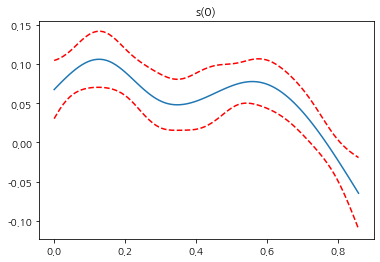

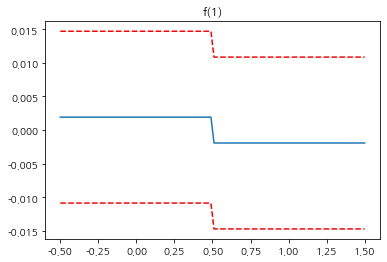

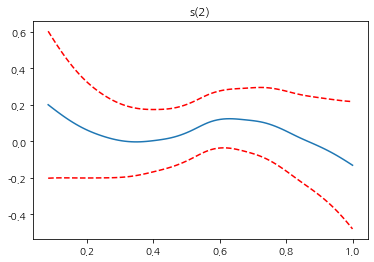

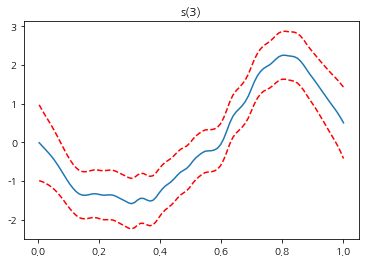

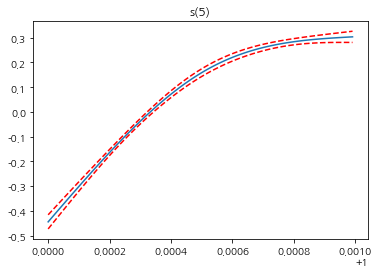

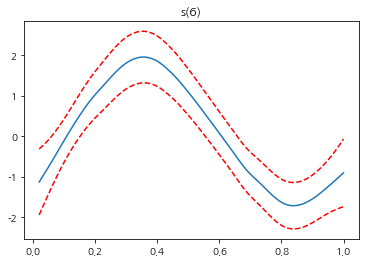

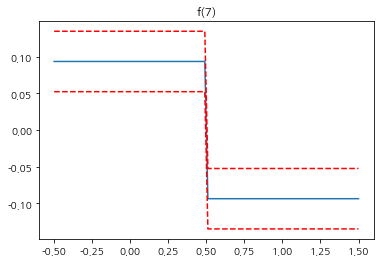

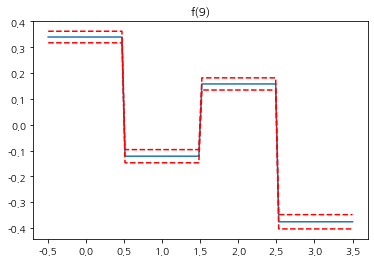

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                     51.5945
Link Function:                          LogLink Log Likelihood:                                       -inf
Number of Samples:                         4384 AIC:                                                   inf
                                                AICc:                                                  inf
                                                UBRE:                                               2.4448
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.7819
Feature Function                  Lam

C:\Users\s_dojh99\AppData\Local\Temp/ipykernel_33924/3206243388.py:14: UserWarning:

KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 




In [21]:
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()

gam.summary()

In [22]:
from sklearn.ensemble import RandomForestRegressor

randomForest = RandomForestRegressor(criterion='mse',n_estimators=1000)

randomForest.fit(trainX,trainy)
rf_val_yhat=randomForest.predict(valX)
mae = np.mean(np.abs(rf_val_yhat-valY.values))
print(mae)

2.3110967369863


In [23]:
from sklearn.ensemble import ExtraTreesRegressor

extratrees = ExtraTreesRegressor(criterion='mse',n_estimators=1000)

extratrees.fit(trainX,trainy)
ets_val_yhat=extratrees.predict(valX)
mae = np.mean(np.abs(ets_val_yhat-valY.values))
print(mae)

2.2946236534246567


In [24]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()

dt.fit(trainX,trainy)
dt_val_yhat=dt.predict(valX)
mae = np.mean(np.abs(dt_val_yhat-valY.values))
print(mae)

2.4836164383561643


In [25]:
from sklearn.tree import ExtraTreeRegressor

et = ExtraTreeRegressor()

et.fit(trainX,trainy)
et_val_yhat=et.predict(valX)
mae = np.mean(np.abs(et_val_yhat-valY.values))
print(mae)

2.2841575342465754


In [26]:
from catboost import CatBoostRegressor

DEV="cpu"

params = {
    'learning_rate': 0.01, 
    #'max_depth':8,
    'objective': 'MAE',
    'early_stopping_rounds' : 10000,
    'eval_metric':'MAE',
    'iterations':50000,
    'random_seed':42,
    'metric_period':1000,
    #'boosting':'dart',
}

if DEV.upper() == "GPU" : 
    params['task_type'] = "GPU"
    params['boosting_type'] = 'Plain'

reg = CatBoostRegressor(**params)
reg.fit(X=trainX, y = trainy, eval_set = [(valX,valY)])

cat_val_yhat = reg.predict(valX)
print("==================================")

mae = np.mean(np.abs(cat_val_yhat-valY.values))
print(mae)

<frozen importlib._bootstrap>:228: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject



0:	learn: 2.2047256	test: 3.6664886	best: 3.6664886 (0)	total: 141ms	remaining: 1h 57m 52s
1000:	learn: 0.7165897	test: 2.0553919	best: 2.0323152 (636)	total: 1.87s	remaining: 1m 31s
2000:	learn: 0.6401203	test: 2.1018622	best: 2.0323152 (636)	total: 3.6s	remaining: 1m 26s
3000:	learn: 0.5889128	test: 2.1238175	best: 2.0323152 (636)	total: 5.59s	remaining: 1m 27s
4000:	learn: 0.5471816	test: 2.1449104	best: 2.0323152 (636)	total: 7.63s	remaining: 1m 27s
5000:	learn: 0.5194099	test: 2.1589202	best: 2.0323152 (636)	total: 9.68s	remaining: 1m 27s
6000:	learn: 0.4947725	test: 2.1643177	best: 2.0323152 (636)	total: 11.7s	remaining: 1m 25s
7000:	learn: 0.4758562	test: 2.1720516	best: 2.0323152 (636)	total: 13.6s	remaining: 1m 23s
8000:	learn: 0.4558263	test: 2.1810784	best: 2.0323152 (636)	total: 15.7s	remaining: 1m 22s
9000:	learn: 0.4403891	test: 2.1872360	best: 2.0323152 (636)	total: 17.8s	remaining: 1m 20s
10000:	learn: 0.4276536	test: 2.1917808	best: 2.0323152 (636)	total: 19.8s	remaini

In [27]:
import lightgbm as lgb

d_train = lgb.Dataset(trainX, label=trainy)
d_val = lgb.Dataset(valX,label = valY)
params = {
    'learning_rate': 0.005, 
    #'max_depth':8,
    'objective': 'regression',
    #'early_stopping_rounds' : 10000,
    'metric':'MAE',
    'sub_feature':0.5,
    'max_depth':10,
    'boosting':'dart',
}

clf = lgb.train(params, d_train,10000,valid_sets=[d_val])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 345
[LightGBM] [Info] Number of data points in the train set: 4384, number of used features: 10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 4.045137
[1]	valid_0's l1: 3.37308
[2]	valid_0's l1: 3.36974
[3]	valid_0's l1: 3.36542
[4]	valid_0's l1: 3.36145
[5]	valid_0's l1: 3.35421
[6]	valid_0's l1: 3.34997
[7]	valid_0's l1: 3.3493
[8]	valid_0's l1: 3.35

In [28]:
from sklearn.neighbors import KNeighborsRegressor

knr = KNeighborsRegressor()

knr.fit(trainX,trainy)
knr_val_yhat=knr.predict(valX)
mae = np.mean(np.abs(knr_val_yhat-valY.values))
print(mae)

2.890038356164384


In [29]:
from sklearn.linear_model import ElasticNet

elastic = ElasticNet()

elastic.fit(trainX,trainy)
elastic_val_yhat=elastic.predict(valX)
mae = np.mean(np.abs(elastic_val_yhat-valY.values))
print(mae)

3.3505534271572848


In [30]:
from sklearn.linear_model import Lasso

lasso = Lasso()

lasso.fit(trainX,trainy)
lasso_val_yhat=lasso.predict(valX)
mae = np.mean(np.abs(lasso_val_yhat-valY.values))
print(mae)

3.377452077292271


In [31]:
from sklearn.svm import SVR

svr = SVR()

svr.fit(trainX,trainy)
svr_val_yhat=svr.predict(valX)
mae = np.mean(np.abs(svr_val_yhat-valY.values))
print(mae)

3.1489343492954953


In [32]:
from sklearn.ensemble import AdaBoostRegressor

ada = AdaBoostRegressor()

ada.fit(trainX,trainy)
ada_val_yhat=ada.predict(valX)
mae = np.mean(np.abs(ada_val_yhat-valY.values))
print(mae)

2.417771307284892


In [33]:
from sklearn.ensemble import BaggingRegressor

bagging = BaggingRegressor()

bagging.fit(trainX,trainy)
bagging_val_yhat=bagging.predict(valX)
mae = np.mean(np.abs(bagging_val_yhat-valY.values))
print(mae)

2.28898


In [34]:
from sklearn.ensemble import GradientBoostingRegressor

gd = GradientBoostingRegressor()

gd.fit(trainX,trainy)
gd_val_yhat=gd.predict(valX)
mae = np.mean(np.abs(gd_val_yhat-valY.values))
print(mae)

2.210355455700771


In [35]:
from sklearn.linear_model import TheilSenRegressor

theilsen = TheilSenRegressor()

theilsen.fit(trainX,trainy)
theilsen_val_yhat=theilsen.predict(valX)
mae = np.mean(np.abs(theilsen_val_yhat-valY.values))
print(mae)

11.409476855533475


In [36]:
from sklearn.linear_model import HuberRegressor

huber = HuberRegressor()

huber.fit(trainX,trainy)
huber_val_yhat=huber.predict(valX)
mae = np.mean(np.abs(huber_val_yhat-valY.values))
print(mae)

3.3607524536715836


c:\Users\s_dojh99\Miniconda3\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



In [37]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor()

ransac.fit(trainX,trainy)
ransac_val_yhat=ransac.predict(valX)
mae = np.mean(np.abs(ransac_val_yhat-valY.values))
print(mae)

4966649.754030898
